In [ ]:
# --- 0) Imports & project path wiring ---
import sys, pathlib
root = pathlib.Path.cwd()
PROJ = None
for p in [root, *root.parents]:
    if (p / "src").exists():
        PROJ = p
        break
if PROJ is None:
    PROJ = root
SRC = PROJ / "src"
# Add the project ROOT to sys.path so 'src' is importable as a package
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
# print("Using project root:", PROJ)  # avoid printing absolute path

# Ensure we use the latest edits in src during interactive work
import importlib
import src.io_axona as _io_axona
importlib.reload(_io_axona)

from src.io_axona import find_session_files, load_pos_axona, load_units_t64, load_units_mclust
from src.analysis import (
    plot_arena,
    occupancy_map,
    center_mask,
    plot_coverage,
    rate_map,
    plot_rate_map,
    path_plus_spikes,
    ARENA_CM,
)
import matplotlib.pyplot as plt
import numpy as np

Using project root: c:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps


In [ ]:
# --- 1) Choose your session directory (requested) ---
session_dir = PROJ / "data/Blackstad_CA1/25398/2019-04-29"
print("session_dir:", session_dir.as_posix().replace(PROJ.as_posix()+"/", ""))

WindowsPath('C:/Users/ashar/OneDrive/Desktop/projects/ca1-tetrode-placemaps/data/Blackstad_CA1/25398/2019-04-29')

In [ ]:
# --- 2) Discover and list data files ---
files = find_session_files(session_dir)
pos_file = files.get("pos")
set_file = files.get("set")
t64_list = files.get("t64_list", [])
tetrode_files = files.get("tetrodes", [])

print("Session:", session_dir.as_posix().replace(PROJ.as_posix()+"/", ""))
print("  .pos:", pos_file.name if pos_file else None)
print("  .set:", set_file.name if set_file else None)
print("  .t64 files:", len(t64_list))
for f in sorted(t64_list)[:12]:
    print("   -", f.name)
print("  .1–.8 tetrode files:", len(tetrode_files))
for f in sorted(tetrode_files)[:8]:
    print("   -", f.name)

Session: C:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\25398\2019-04-29
  .pos: C:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\25398\2019-04-29\2019-04-29.pos
  .set: C:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\25398\2019-04-29\2019-04-29.set
  .t64 files: 14
   - 2019-04-29_2_01.t64
   - 2019-04-29_2_02.t64
   - 2019-04-29_2_03.t64
   - 2019-04-29_2_04.t64
   - 2019-04-29_2_05.t64
   - 2019-04-29_2_06.t64
   - 2019-04-29_3_01.t64
   - 2019-04-29_3_02.t64
   - 2019-04-29_3_03.t64
   - 2019-04-29_3_04.t64
   - 2019-04-29_3_05.t64
   - 2019-04-29_3_06.t64
  .1–.8 tetrode files: 8
   - 2019-04-29.1
   - 2019-04-29.2
   - 2019-04-29.3
   - 2019-04-29.4
   - 2019-04-29.5
   - 2019-04-29.6
   - 2019-04-29.7
   - 2019-04-29.8


In [4]:
# --- 3) Load and preview the .pos file ---
pos_df = load_pos_axona(pos_file)
pos_df.head()

,t,x,y,ang,valid,speed,keep
0,0.00,41.000000,44.666667,NaN,1,16.666667,True
1,0.02,41.333333,44.666667,NaN,1,18.633900,True
2,0.04,41.333333,45.333333,NaN,1,106.066017,False
3,0.06,44.333333,41.666667,NaN,1,26.352314,True
4,0.08,41.666667,46.333333,NaN,1,11.785113,True


In [5]:
# === Display-normalize position to a 150 cm square and center it ===
import numpy as np

ARENA_CM = 150  # keep consistent with your analysis/plotting

def normalize_to_arena(df, arena_cm=ARENA_CM, pad_frac=0.0):
    """
    Non-destructive: returns a copy.
    1) Remove NaNs for range estimation
    2) Translate so min(x,y)=0
    3) Uniformly scale to fit inside [0, arena_cm] with optional padding
    4) Center in both axes
    """
    d = df.copy()
    x = d["x"].to_numpy(dtype=float)
    y = d["y"].to_numpy(dtype=float)
    m = np.isfinite(x) & np.isfinite(y)
    if not np.any(m):
        return d  # nothing to do

    x_min, x_max = float(np.nanmin(x[m])), float(np.nanmax(x[m]))
    y_min, y_max = float(np.nanmin(y[m])), float(np.nanmax(y[m]))
    xr, yr = (x_max - x_min), (y_max - y_min)
    if xr <= 0 or yr <= 0:
        return d

    # (1) zero-base
    d["x"] = d["x"] - x_min
    d["y"] = d["y"] - y_min

    # (2) uniform scale so the longer side fits, with optional padding
    usable = arena_cm * (1.0 - 2.0 * pad_frac)
    s = min(usable / xr, usable / yr)

    d["x"] = d["x"] * s
    d["y"] = d["y"] * s

    # (3) center inside the square
    new_xr = xr * s
    new_yr = yr * s
    x_off = (arena_cm - new_xr) / 2.0
    y_off = (arena_cm - new_yr) / 2.0
    d["x"] = d["x"] + x_off
    d["y"] = d["y"] + y_off

    # Optional: sanity print
    xmin, xmax = float(np.nanmin(d["x"])), float(np.nanmax(d["x"]))
    ymin, ymax = float(np.nanmin(d["y"])), float(np.nanmax(d["y"]))
    print(f"[normalize] x:[{xmin:.2f}, {xmax:.2f}]  y:[{ymin:.2f}, {ymax:.2f}]  scale:{s:.3f}")
    return d

# --- call it right after your loader ---
# pos_df = load_pos_axona(files["pos"])
pos_df = normalize_to_arena(pos_df, arena_cm=ARENA_CM, pad_frac=0.00)  # set 0.05 for 5% margins, if desired


[normalize] x:[-0.00, 150.00]  y:[0.88, 149.12]  scale:1.051


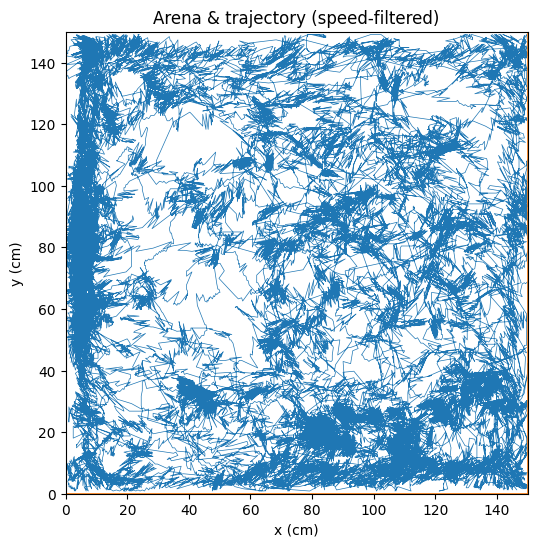

In [6]:
# --- 4) Plot arena & trajectory ---
plot_arena(pos_df)

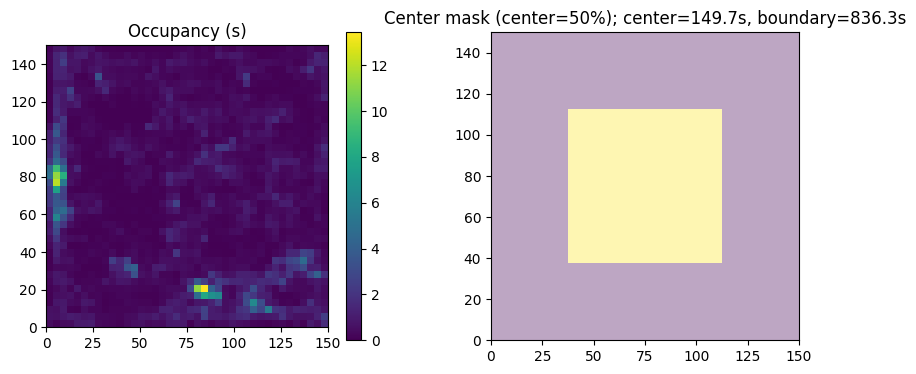

In [7]:
# --- 5) Coverage (boundary & centre) ---
BINS = 40
plot_coverage(pos_df, bins=BINS, center_frac=0.5)

In [8]:
# --- 6) Load cluster cuts and choose a unit ---
try:
    units = load_units_mclust(session_dir)
except Exception:
    units = {}
if not units:
    units = load_units_t64(session_dir)
print(f"Loaded {len(units)} units")
if units:
    (tet, clu), spike_ts = next(iter(units.items()))
    tet, clu, spike_ts[:10]
else:
    tet = clu = None
    spike_ts = np.array([])
    print("No units found; you can still run occupancy/coverage plots.")

Loaded 0 units
No units found; you can still run occupancy/coverage plots.


In [9]:
# --- 7) Path + spike locations for this unit ---
if spike_ts.size:
    path_plus_spikes(pos_df, spike_ts)
else:
    print("Skipping spike overlay: no units found.")

Skipping spike overlay: no units found.


In [10]:
# --- 8) Place map (firing-rate heatmap) ---
if spike_ts.size:
    R = rate_map(pos_df, spike_ts, bins=BINS, sigma=1.0)
    plot_rate_map(R, title=f"T{tet} U{clu} — Rate map (Hz)")
else:
    print("Skipping rate map: no units found.")

Skipping rate map: no units found.


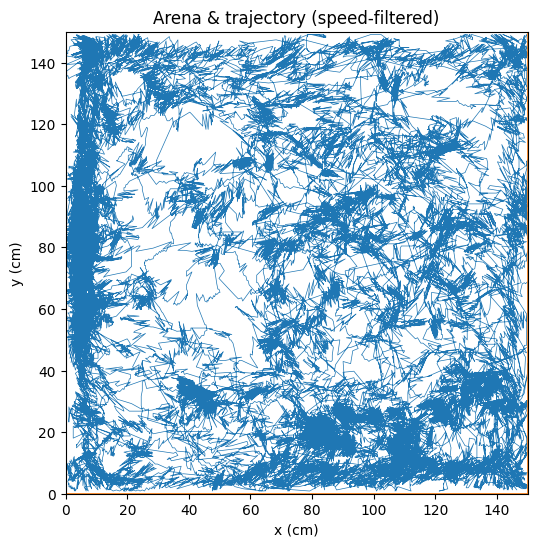

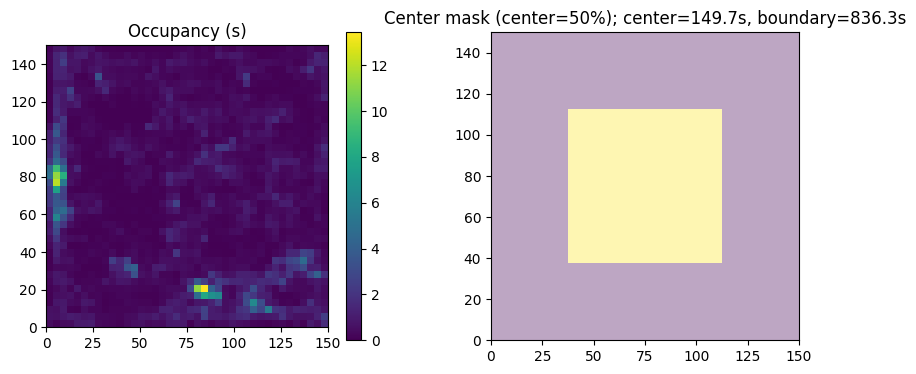

No units to export rate maps for.
Saved figures in: C:\Users\ashar\OneDrive\Desktop\projects\ca1-tetrode-placemaps\data\Blackstad_CA1\25398\2019-04-29\maps


In [ ]:
# --- 9) Batch export figures ---
outdir = session_dir / "maps"
outdir.mkdir(exist_ok=True)

# Arena & coverage
plot_arena(pos_df); plt.savefig(session_dir / "arena_path.png", dpi=200); plt.close()
plot_coverage(pos_df, bins=BINS, center_frac=0.5); plt.savefig(session_dir / "coverage.png", dpi=200); plt.close()

if units:
    for (tet, clu), spike_ts in units.items():
        path_plus_spikes(pos_df, spike_ts); plt.savefig(outdir / f"T{tet}_U{clu}_path_spikes.png", dpi=200); plt.close()
        R = rate_map(pos_df, spike_ts, bins=BINS, sigma=1.0)
        plt.figure(figsize=(5,5))
        plt.imshow(R, origin="lower", extent=[0,ARENA_CM,0,ARENA_CM])
        plt.title(f"T{tet} U{clu} — Rate map (Hz)")
        plt.colorbar(); plt.tight_layout()
        plt.savefig(outdir / f"T{tet}_U{clu}_ratemap.png", dpi=200); plt.close()
else:
    print("No units to export rate maps for.")

rel_out = outdir.as_posix().replace(PROJ.as_posix()+"/", "")
print("Saved figures in:", rel_out)